In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, time, torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import transforms


def get_clip_bounds(mean, std, dim):
    """
    Function computes the minimum and maximum clamping bounds
    using the mean and standard deviation of the dataset

    Arguments:
        mean : Mean for each channel of the dataset
        std  : Standard deviation for each channel of the dataset
        dim  : Dimension of the input images of the model

    Returns:
        clip_min : Tensor with the minimum values allowed for each channel
        clip_max : Tensor with the maximum values allowed for each channel
    """

    clip_shape = [1, dim, dim]

    if isinstance(mean, (list, tuple, np.ndarray)):
        clip_min = []
        clip_max = []

        for i in range(len(mean)):
            clip_min.append(torch.full(clip_shape, (0.0 - mean[i]) / std[i]))
            clip_max.append(torch.full(clip_shape, (1.0 - mean[i]) / std[i]))

        clip_min = torch.cat(clip_min)
        clip_max = torch.cat(clip_max)
    else:
        clip_min = torch.full(clip_shape, (0.0 - mean) / std)
        clip_max = torch.full(clip_shape, (1.0 - mean) / std)

    return clip_min, clip_max


def deepfool(model, clip_min, clip_max, images, labels=None, l2_norm=True,
             batch_size=10, num_classes=10, overshoot=0.02, max_iters=50):
    """
    Function implements the DeepFool adversarial attack from the paper
    'DeepFool: a simple and accurate method to fool deep neural networks'
    [https://arxiv.org/pdf/1511.04599.pdf]

    Input Arguments:
        model       : Model to attack using DeepFool
        clip_min    : Minimum boundary of the adversarial images
        clip_max    : Maximum boundary of the adversarial images
        images      : Original images of the dataset
        labels      : True labels of the images of the dataset, else if set
                      to None, predictions of the model are used instead of
                      the true labels
                      (Default = None)
        l2_norm     : Flag used to determine if perturbations use L2 norm,
                      else if set to false, L-inf norm is used instead
                      (Default = True)
        batch_size  : Batch size used for the output logits of the model
                      (Default = 10)
        num_classes : Number of classes to use for the prediction result of
                      the aversarial images
                      (Default = 10)
        overshoot   : Constant used to scale the adversarial perturbations
                      (Default = 0.02)
        max_iters   : Maximum iterations allowed for generating an adversarial
                      image for each image
                      (Default = 50)

    Outputs:
        images_adv  : Adversarial images generated from DeepFool
        images_pert : Perturbations generated from DeepFool
        confs_adv   : Model confidences of the adversarial images
        labels_adv  : Model predictions of the adversarial images
        iters       : Total iterations it took for each adversarial image
    """

    images_adv = []
    images_pert = []
    confs_adv = []
    labels_adv = []
    iters = []

    device = images.get_device()

    # Create a tensor with all class labels
    # and split the tensor into batches
    k_all = torch.arange(0, num_classes).long().to(device)
    k_batch = k_all.split(batch_size)

    # Get the batch length and the size of the last batch,
    # in case it has a different size from the rest
    batch_length = len(k_batch)
    batch_size_last = len(k_batch[-1])

    # Use the negative log likelihood loss function without the
    # following softmax activation, as recommended in the paper
    loss_fn = nn.NLLLoss(reduction='sum')

    # Generate the adversarial image for each input image
    for i in range(len(images)):
        # Use a batch size of 1 for the input image and
        # intialize the perturbation with values of zero
        image = images[i].unsqueeze(dim=0).detach()
        r_hat = torch.zeros(image.shape).to(device)
        x = image

        # Duplicate the image so it has the same
        # batch size as the class label batch size
        x_batch = x.repeat(batch_size, 1, 1, 1)
        x_batch.requires_grad = True
        x_batch_last = x.repeat(batch_size_last, 1, 1, 1)
        x_batch_last.requires_grad = True

        # Get the model logit values of the image and
        # get the max confidence and predicted label
        f_k = model(x_batch)
        conf_i, k_i = f_k[0].max(dim=0)
        conf_i = conf_i.detach()

        # Create a list with labels not equal to the predicted label if
        # the true label is not known, or the true label if its known
        if labels is None:
            k_0 = k_i
        else:
            k_0 = labels[i]
        k_wrong = k_all[k_all != k_0]

        # Set the flag as true if the label 'k_0' is outside the tensor
        # containing the class indices with the range of 'num_classes'
        out_of_bounds = (False if (k_0 in k_all) else True)

        # Loop until max iterations are reached or if the
        # adversarial image causes the model to misclassify
        for j in range(max_iters):
            if not k_i.eq(k_0):
                break

            # Compute the gradient for the logit value of the
            # label 'k_0' if its out of bounds of 'num_classes'
            w_k0 = None
            if out_of_bounds:
                f_k[0][k_0].backward(retain_graph=True)
                w_k0 = x_batch.grad.detach().clone()[0].unsqueeze(dim=0)
                x_batch.grad.zero_()

            # Compute the gradients for all logit values of the model output
            w_k = []
            for k in range(batch_length):
                if k == (batch_length - 1):
                    f_k = model(x_batch_last)
                    x_batch = x_batch_last
                    loss_fn(f_k, k_batch[k]).backward(retain_graph=False)
                else:
                    loss_fn(f_k, k_batch[k]).backward(retain_graph=True)
                w_k.append(-x_batch.grad.detach().clone())
                x_batch.grad.zero_()
            w_k = torch.cat(w_k)

            # Compute the difference between gradient/logit values for the
            # wrong labels and the gradient/logit value for the label 'k_0'
            if out_of_bounds:
                w_p = w_k[k_wrong] - w_k0
            else:
                w_p = w_k[k_wrong] - w_k[k_0]
            f_p = (f_k[0][k_wrong] - f_k[0][k_0]).detach()

            # Compute the perturbation scalars and get the index for the
            # perturbation scalar that resulted in the smallest value
            if l2_norm:
                perts = f_p.abs() / w_p.flatten(start_dim=1).norm(dim=1, p=2)
            else:
                perts = f_p.abs() / w_p.flatten(start_dim=1).norm(dim=1, p=1)
            l_hat = perts.min(dim=0)[1]

            # Compute the minimum perturbation and sum it with the previous
            # perturbations (Authors of paper did not mention a constant
            # added to the perturbation scalar, but it helps reduce the
            # number of iterations needed to fool the classifier)
            if l2_norm:
                r_i = (perts[l_hat] + 1e-4) * w_p[l_hat] / w_p[l_hat].norm(p=2)
            else:
                r_i = (perts[l_hat] + 1e-4) * w_p[l_hat].sign()
            r_hat += r_i

            # Project the perturbation scaled with the overshoot
            # value over the input image and clamp the adversarial
            # image using the minimum and maximum bounds
            x = image + (1 + overshoot) * r_hat
            x = torch.max(torch.min(x, clip_max), clip_min)

            # Duplicate the adversarial image so it has the
            # same batch size as the class label batch size
            x_batch = x.repeat(batch_size, 1, 1, 1)
            x_batch.requires_grad = True
            x_batch_last = x.repeat(batch_size_last, 1, 1, 1)
            x_batch_last.requires_grad = True

            # Get the model logit values of the aversarial image
            # and get the max confidence and predicted label
            f_k = model(x_batch)
            conf_i, k_i = f_k[0].max(dim=0)
            conf_i = conf_i.detach()

            del w_k0, w_k, w_p, f_p
            del perts, l_hat, r_i

        images_adv.append(x)
        images_pert.append(x - image)
        confs_adv.append(conf_i.unsqueeze(dim=0))
        labels_adv.append(k_i.unsqueeze(dim=0))
        iters.append(j)

        del image, r_hat, x, x_batch, x_batch_last
        del f_k, conf_i, k_i, k_0, k_wrong

    images_adv = torch.cat(images_adv)
    images_pert = torch.cat(images_pert)
    confs_adv = torch.cat(confs_adv)
    labels_adv = torch.cat(labels_adv)

    del k_all, k_batch

    return images_adv, images_pert, confs_adv, labels_adv, iters


def fgsm(model, clip_min, clip_max, images, labels, eps=0.007):
    """
    Function implements the FGSM adversarial attack from the paper
    'Explaining and Harnessing Adversarial Examples'
    [https://arxiv.org/pdf/1412.6572.pdf]

    Input Variables:
        model    : Model to attack using FGSM
        clip_min : Minimum boundary of the adversarial images
        clip_max : Maximum boundary of the adversarial images
        images   : Original images of the dataset
        labels   : True labels of the images of the dataset
        eps      : Scalar used for the adversarial perturbations
                   (Default = 0.007)

    Output Variables:
        images_adv  : Adversarial images generated from FGSM
        images_pert : Perturbations generated from FGSM
        confs_adv   : Model confidences of the adversarial images
        labels_adv  : Model predictions of the adversarial images
    """

    images_grad = images.detach()
    images_grad.requires_grad = True

    loss_fn = nn.CrossEntropyLoss()

    # Compute the loss of the model outputs and perform
    # backpropagation to compute the gradients of the images
    outputs = model(images_grad)
    loss_fn(outputs, labels).backward()

    # Project the scaled gradient over the input images and clamp
    # the adversarial images using the minimum and maximum bounds
    images_adv = images.detach() + eps * images_grad.grad.sign()
    images_adv = torch.max(torch.min(images_adv, clip_max), clip_min)
    images_pert = images_adv - images.detach()

    # Get the confidences and predictions of the adversarial images
    with torch.no_grad():
        outputs = model(images_adv)
    confs_adv, labels_adv = outputs.max(dim=1)

    del images_grad, outputs

    return images_adv, images_pert, confs_adv, labels_adv


def compute_robustness(x, r_hat):
    """
    Function computes the adversarial robustness using the equation from the
    paper 'DeepFool: a simple and accurate method to fool deep neural networks'
    [https://arxiv.org/pdf/1511.04599.pdf]

    Input Variables:
        x     : Original images of the dataset
        r_hat : Perturbations generated from the images

    Output Variables:
        p_adv : Robustness value of each perturbation
    """

    p_adv = (r_hat.flatten(start_dim=1).norm(dim=1) \
        / x.flatten(start_dim=1).norm(dim=1)).cpu().numpy()

    return p_adv


def evaluate_attack(file_name, file_dir, device, model, dataset_loader,
                    clip_min, clip_max, adv_args, is_fgsm=True,
                    has_labels=False, l2_norm=True, verbose=True):
    """
    Function evaluates the adversarial attack method chosen (FGSM or DeepFool)
    and saves the results in a .csv file

    Input Variables:
        file_name      : Name of the .csv file
        file_dir       : Directory where the .csv file will be saved
        device         : Device to forward the tensors to (CPU or GPU)
        model          : Model to attack using FGSM or DeepFool
        dataset_loader : Dataset to use for the adversarial images
        clip_min       : Minimum boundary of the adversarial images
        clip_max       : Maximum boundary of the adversarial images
        adv_args       : Epsilon parameter for FGSM or parameters for DeepFool
                         eps or [batch_size, num_classes, overshoot, max_iters]
        is_fgsm        : Flag used to set the adversarial attack as FGSM, or
                         DeepFool if false
                         (Default = True)
        has_labels     : Flag used to determine if the DeepFool adversarial
                         attack has access to the true labels of the dataset
                         (Default = False)
        l2_norm        : Flag used to determine if DeepFool perturbations use L2
                         norm, else if set to false, L-inf norm is used instead
                         (Default = True)
        verbose        : Prints the batch progress if set to True
                         (Default = True)

    Output Variables:
        None
    """

    model.eval()

    file_path = os.path.join(file_dir, file_name)

    if not os.path.isdir(file_dir):
        os.makedirs(file_dir, exist_ok=True)

    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
    else:
        df = pd.DataFrame(columns=['batch_idx', 'correct', 'p_adv', 'time'])
        df.to_csv(file_path, index=False, header=True)

    if is_fgsm:
        name = 'FGSM'
    else:
        name = 'DeepFool'

    length_batches = len(dataset_loader)
    length_dataset = len(dataset_loader.dataset)
    length_df = len(df.index)

    if length_df < length_batches:
        for batch_idx, (images, labels) in enumerate(dataset_loader):
            if batch_idx < length_df:
                continue

            images, labels = images.to(device), labels.to(device)
            time_start = time.time()

            if is_fgsm:
                _, perts, _, labels_adv = fgsm(
                    model, clip_min, clip_max, images, labels, adv_args)
            elif has_labels:
                _, perts, _, labels_adv, _ = deepfool(
                    model, clip_min, clip_max, images, labels, l2_norm,
                    adv_args[0], adv_args[1], adv_args[2], adv_args[3])
            else:
                _, perts, _, labels_adv, _ = deepfool(
                    model, clip_min, clip_max, images, None, l2_norm,
                    adv_args[0], adv_args[1], adv_args[2], adv_args[3])

            time_batch = time.time() - time_start
            correct = (labels_adv == labels).sum().item()
            p_adv = np.mean(compute_robustness(images, perts))

            df = pd.DataFrame({'batch_idx' : [batch_idx],
                               'correct' : [correct],
                               'p_adv' : [p_adv],
                               'time' : [time_batch]})
            df.to_csv(file_path, mode='a', index=False, header=False)

            if verbose:
                if batch_idx < (length_batches - 1):
                    print('{:s} Batches Complete : ({:d} / {:d})'\
                        .format(name, batch_idx + 1, length_batches), end='\r')
                else:
                    print('{:s} Batches Complete : ({:d} / {:d})'\
                        .format(name, batch_idx + 1, length_batches))

            del images, labels, perts, labels_adv

    df = pd.read_csv(file_path).to_numpy().T

    test_error = (1.0 - (np.sum(df[1]) / length_dataset)) * 100.0
    robustness = np.mean(df[2])
    time_images = np.sum(df[3])
    time_image = time_images / length_dataset

    print('{:s} Test Error : {:.2f}%'.format(name, test_error))
    print('{:s} Robustness : {:.2e}'.format(name, robustness))
    print('{:s} Time (All Images) : {:.2f} s'.format(name, time_images))
    if int(time_image) != 0.0:
        print('{:s} Time (Per Image) : {:.2f} s'.format(name, time_image))
    elif int(time_image * 1e3) != 0.0:
        print('{:s} Time (Per Image) : {:.2f} ms'.format(name, time_image * 1e3))
    else:
        print('{:s} Time (Per Image) : {:.2f} us'.format(name, time_image * 1e6))


def display_attack(device, model, test_dataset, inv_tf, clip_min, clip_max,
                   fgsm_eps, deep_args, has_labels=False, l2_norm=True,
                   pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11,
                   label_map=None):
    """
    Function displays the images and predictions of the FGSM and DeepFool
    adversarial attacks

    Input Variables:
        device       : Device to forward the tensors to (CPU or GPU)
        model        : Model to attack using FGSM and DeepFool
        test_dataset : Test dataset used for the labels and images of the
                       adverarial attacks
        inv_tf       : Inverse transform to de-normalize the dataset images
        clip_min     : Minimum boundary of the adversarial images
        clip_max     : Maximum boundary of the adversarial images
        fgsm_eps     : Epsilon parameter for FGSM adversarial attack
        deep_args    : List of parameters for DeepFool adversarial attack
                       [batch_size, num_classes, overshoot, max_iters]
        has_labels   : Flag used to determine if the DeepFool adversarial
                       attack has access to the true labels of the dataset
                       (Default = False)
        l2_norm      : Flag used to determine if DeepFool perturbations use L2
                       norm, else if set to false, L-inf norm is used instead
                       (Default = True)
        pert_scale   : Scalar used to increase the perturbation visibility
                       (Default = 1.0)
        fig_rows     : Number of images to display in the figure
                       (Default = 2)
        fig_width    : Width of the figure
                       (Default = 25)
        fig_height   : Height of the figure
                       (Default = 11)
        label_map    : List that maps the label index to name of the label
                       (Default = None)

    Output Variables:
        None
    """

    model.eval()

    fig = plt.figure(figsize=(fig_width, fig_height), facecolor='white')

    test_loader = DataLoader(test_dataset, batch_size=fig_rows,
                             shuffle=True, num_workers=4)

    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    if images.shape[1] == 1:
        is_gray = True
    else:
        is_gray = False

    with torch.no_grad():
        confs_pred, labels_pred = model(images).max(dim=1)

    advs_fgsm, perts_fgsm, confs_fgsm, labels_fgsm = fgsm(
        model, clip_min, clip_max, images, labels, fgsm_eps)

    if has_labels:
        advs_deep, perts_deep, confs_deep, labels_deep, iters_deep = deepfool(
            model, clip_min, clip_max, images, labels, l2_norm,
            deep_args[0], deep_args[1], deep_args[2], deep_args[3])
    else:
        advs_deep, perts_deep, confs_deep, labels_deep, iters_deep = deepfool(
            model, clip_min, clip_max, images, None, l2_norm,
            deep_args[0], deep_args[1], deep_args[2], deep_args[3])

    p_adv_fgsm = compute_robustness(images, perts_fgsm)
    p_adv_deep = compute_robustness(images, perts_deep)

    images_1 = inv_tf(images)
    images_2 = inv_tf(advs_fgsm)
    images_3 = inv_tf(advs_deep)
    images_4 = inv_tf(perts_fgsm * pert_scale)
    images_5 = inv_tf(perts_deep * pert_scale)

    for i in range(fig_rows):
        image_1 = transforms.ToPILImage()(images_1[i])
        image_2 = transforms.ToPILImage()(images_2[i])
        image_3 = transforms.ToPILImage()(images_3[i])
        image_4 = transforms.ToPILImage()(images_4[i])
        image_5 = transforms.ToPILImage()(images_5[i])

        label_true = labels[i].item()
        label_pred = labels_pred[i].item()
        label_fgsm = labels_fgsm[i].item()
        label_deep = labels_deep[i].item()

        if label_map is not None:
            label_true = label_map[label_true]
            label_pred = label_map[label_pred]
            label_fgsm = label_map[label_fgsm]
            label_deep = label_map[label_deep]

        fig.add_subplot(fig_rows, 5, (i * 5) + 1)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('true label : {:s}\npred label : {:s}\nconf score : {:.2f}'\
            .format(str(label_true), str(label_pred), confs_pred[i].item()),
            fontsize=16, loc='left')
        if i == 0:
            plt.title(label='Original', fontsize=20)
        if is_gray:
            plt.imshow(image_1, cmap='gray')
        else:
            plt.imshow(image_1)

        fig.add_subplot(fig_rows, 5, (i * 5) + 2)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('pred label : {:s}\nconf score : {:.2f}'\
            .format(str(label_fgsm), confs_fgsm[i].item()),
            fontsize=16, loc='left')
        if i == 0:
            plt.title(label='Adversarial (FGSM)', fontsize=20)
        if is_gray:
            plt.imshow(image_2, cmap='gray')
        else:
            plt.imshow(image_2)

        fig.add_subplot(fig_rows, 5, (i * 5) + 3)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('pred label : {:s}\nconf score : {:.2f}'\
            .format(str(label_deep), confs_deep[i].item()),
            fontsize=16, loc='left')
        if i == 0:
            plt.title(label='Adversarial (DeepFool)', fontsize=20)
        if is_gray:
            plt.imshow(image_3, cmap='gray')
        else:
            plt.imshow(image_3)

        fig.add_subplot(fig_rows, 5, (i * 5) + 4)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('robustness : {:.2e}\neps : {:s}'\
            .format(p_adv_fgsm[i], str(fgsm_eps)),
            fontsize=16, loc='left')
        if i == 0:
            plt.title(label='Perturbation (FGSM)', fontsize=20)
        if is_gray:
            plt.imshow(image_4, cmap='gray')
        else:
            plt.imshow(image_4)

        fig.add_subplot(fig_rows, 5, (i * 5) + 5)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('robustness : {:.2e}\novershoot : {:s}\niters : {:d}'\
            .format(p_adv_deep[i], str(deep_args[2]), iters_deep[i]),
            fontsize=16, loc='left')
        if i == 0:
            plt.title(label='Perturbation (DeepFool)', fontsize=20)
        if is_gray:
            plt.imshow(image_5, cmap='gray')
        else:
            plt.imshow(image_5)

    plt.show()

    del images, labels, confs_pred, labels_pred
    del advs_deep, perts_deep, confs_deep, labels_deep
    del advs_fgsm, perts_fgsm, confs_fgsm, labels_fgsm
    del images_1, images_2, images_3, images_4, images_5


def model_train(device, model, opt, epochs, loader_train, loader_val,
                print_step=1, clip_min=None, clip_max=None, adv_args=None,
                is_fgsm=True, has_labels=False, l2_norm=True, verbose=True):
    """
    Function is used to train the model with clean images of the dataset, or
    adversarial images of the dataset if adversarial parameters are passed to
    the function.

    Input Variables:
        device       : Device to forward the tensors to (CPU or GPU)
        model        : Model to train with the training set
        opt          : Optimizer used for training the model
        epochs       : Number of iterations the model is trained on the dataset
        loader_train : Dataset loader for the training set
        loader_val   : Dataset loader for the validation set
        print_step   : Epoch interval to print training and validation results
                       (Default = 1)
        clip_min     : Minimum boundary of the adversarial images
                       (Default = None)
        clip_max     : Maximum boundary of the adversarial images
                       (Default = None)
        adv_args     : Epsilon parameter for FGSM or parameters for DeepFool
                       eps or [batch_size, num_classes, overshoot, max_iters]
                       (Default = None)
        is_fgsm      : Flag used to set the adversarial method for training
                       as FGSM, or DeepFool if false
                       (Default = True)
        has_labels   : Flag used to determine if the DeepFool adversarial
                       attack has access to the true labels of the dataset
                       (Default = False)
        l2_norm      : Flag used to determine if DeepFool perturbations use L2
                       norm, else if set to false, L-inf norm is used instead
                       (Default = True)
        verbose      : Prints the training acc/loss per epoch if set to True
                       (Default = True)

    Output_Variables:
        train_accs   : List containing training accuracy for each epoch
        train_losses : List containing training loss for each epoch
        val_accs     : List containing validation accuracy for each epoch
        val_losses   : List containing validation loss for each epoch
    """

    if (clip_min is None) or (clip_min is None) or (adv_args is None):
        is_adv = False
    else:
        is_adv = True

    loss_fn = nn.CrossEntropyLoss()

    train_accs = []
    train_losses = []

    val_accs = []
    val_losses = []

    for epoch in range(epochs):
        correct = 0
        losses = []

        model.train()

        for images, labels in loader_train:
            images, labels = images.to(device), labels.to(device)

            if is_adv:
                model.eval()
                if is_fgsm:
                    images_input, _, _, _ = fgsm(
                        model, clip_min, clip_max, images, labels, adv_args)
                elif has_labels:
                    images_input, _, _, _, _ = deepfool(
                        model, clip_min, clip_max, images, labels, l2_norm,
                        adv_args[0], adv_args[1], adv_args[2], adv_args[3])
                else:
                    images_input, _, _, _, _ = deepfool(
                        model, clip_min, clip_max, images, None, l2_norm,
                        adv_args[0], adv_args[1], adv_args[2], adv_args[3])
                model.train()
            else:
                images_input = images

            opt.zero_grad()

            outputs = model(images_input)
            loss = loss_fn(outputs, labels)

            correct += (outputs.max(dim=1)[1] == labels).sum().item()
            losses.append(loss.item())

            loss.backward()
            opt.step()

            del images, labels, images_input, outputs

        train_acc = correct / len(loader_train.dataset)
        train_loss = np.mean(losses)

        train_accs.append(train_acc)
        train_losses.append(train_loss)

        correct = 0
        losses = []

        model.eval()

        for images, labels in loader_val:
            images, labels = images.to(device), labels.to(device)

            if is_adv:
                if is_fgsm:
                    images_input, _, _, _ = fgsm(
                        model, clip_min, clip_max, images, labels, adv_args)
                elif has_labels:
                    images_input, _, _, _, _ = deepfool(
                        model, clip_min, clip_max, images, labels, l2_norm,
                        adv_args[0], adv_args[1], adv_args[2], adv_args[3])
                else:
                    images_input, _, _, _, _ = deepfool(
                        model, clip_min, clip_max, images, None, l2_norm,
                        adv_args[0], adv_args[1], adv_args[2], adv_args[3])
            else:
                images_input = images

            with torch.no_grad():
                outputs = model(images_input)
                loss = loss_fn(outputs, labels)

            correct += (outputs.max(dim=1)[1] == labels).sum().item()
            losses.append(loss.item())

            del images, labels, images_input, outputs

        val_acc = correct / len(loader_val.dataset)
        val_loss = np.mean(losses)

        val_accs.append(val_acc)
        val_losses.append(val_loss)

        if verbose and (epoch == 0 or (epoch + 1) % print_step == 0):
            print('Epoch [{:d}]'.format(epoch + 1))
            print('    Train Acc : {:.4f},  Train Loss : {:.4f}'\
                .format(train_acc, train_loss))
            print('      Val Acc : {:.4f},    Val Loss : {:.4f}'\
                .format(val_acc, val_loss))

    return train_accs, train_losses, val_accs, val_losses


def model_eval(device, model, loader_test, clip_min=None, clip_max=None,
               adv_args=None, is_fgsm=True, has_labels=False, l2_norm=True,
               verbose=True):
    """
    Function is used to evaluate the model with clean images of the dataset, or
    adversarial images of the dataset if adversarial parameters are passed to
    the function.

    Input Variables:
        device      : Device to forward the tensors to (CPU or GPU)
        model       : Model to evaluate with the test set
        loader_test : Dataset loader for the testing set
        clip_min    : Minimum boundary of the adversarial images
                      (Default = None)
        clip_max    : Maximum boundary of the adversarial images
                      (Default = None)
        adv_args    : Epsilon parameter for FGSM or parameters for DeepFool
                      eps or[batch_size, num_classes, overshoot, max_iters]
                      (Default = None)
        is_fgsm     : Flag used to set the adversarial method for evaluation
                      as FGSM, or DeepFool if false
                      (Default = True)
        has_labels  : Flag used to determine if the DeepFool adversarial
                      attack has access to the true labels of the dataset
                      (Default = False)
        l2_norm     : Flag used to determine if DeepFool perturbations use L2
                      norm, else if set to false, L-inf norm is used instead
                      (Default = True)
        verbose     : Prints the testing acc/loss if set to True
                      (Default = True)

    Output_Variables:
        test_acc  : Testing set accuracy of the model
        test_loss : Testing set loss of the model
    """

    if (clip_min is None) or (clip_min is None) or (adv_args is None):
        is_adv = False
    else:
        is_adv = True

    loss_fn = nn.CrossEntropyLoss()

    correct = 0
    losses = []

    model.eval()

    for images, labels in loader_test:
        images, labels = images.to(device), labels.to(device)

        if is_adv:
            if is_fgsm:
                images_input, _, _, _ = fgsm(
                    model, clip_min, clip_max, images, labels, adv_args)
            elif has_labels:
                images_input, _, _, _, _ = deepfool(
                    model, clip_min, clip_max, images, labels, l2_norm,
                    adv_args[0], adv_args[1], adv_args[2], adv_args[3])
            else:
                images_input, _, _, _, _ = deepfool(
                    model, clip_min, clip_max, images, None, l2_norm,
                    adv_args[0], adv_args[1], adv_args[2], adv_args[3])
        else:
            images_input = images

        with torch.no_grad():
            outputs = model(images_input)
            loss = loss_fn(outputs, labels)

        correct += (outputs.max(dim=1)[1] == labels).sum().item()
        losses.append(loss.item())

        del images, labels, images_input, outputs

    test_acc = correct / len(loader_test.dataset)
    test_loss = np.mean(losses)

    if verbose:
        if is_adv:
            if is_fgsm:
                print('Evaluation (FGSM Images)')
            else:
                print('Evaluation (DeepFool Images)')
        else:
            print('Evaluation (Clean Images)')
        print('     Test Acc : {:.4f},   Test Loss : {:.4f}'\
            .format(test_acc, test_loss))

    return test_acc, test_loss

In [ ]:
import torch.nn as nn


class FC_500_150(nn.Module):
    """
    Fully connected linear model with two hidden layers, based on the model
    used in the DeepFool paper
    [https://arxiv.org/pdf/1511.04599.pdf]
    """

    def __init__(self):
        super(FC_500_150, self).__init__()

        self.activation = nn.ReLU()

        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 150)
        self.fc3 = nn.Linear(150, 10)

    def forward(self, x):
        x = x.flatten(start_dim=1)

        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return x


In [2]:
import numpy as np
import os, torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms

In [3]:

rand_seed = 100
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [4]:
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

mnist_min, mnist_max = get_clip_bounds(mnist_mean,
                                       mnist_std,
                                       mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

mnist_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mnist_mean,
        std=mnist_std)])

mnist_tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mnist_mean,
        std=mnist_std)])

mnist_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=0.0,
        std=np.divide(1.0, mnist_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, mnist_std),
        std=1.0)])

mnist_temp = datasets.MNIST(root='datasets/mnist', train=True,
                            download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])

mnist_test = datasets.MNIST(root='datasets/mnist', train=False,
                            download=True, transform=mnist_tf)

100%|██████████| 9912422/9912422 [04:54<00:00, 33708.23it/s]


Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 130788.68it/s]


Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:50<00:00, 32366.15it/s]


Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 10879799.41it/s]

Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



In [5]:
batch_size = 128
workers = 4

mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size,
                                shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size,
                              shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size,
                               shuffle=False, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
train_model = True

epochs = 50

lr = 0.004
lr_nin = 0.01

momentum = 0.9

print_step = 5

if not os.path.isdir('weights/clean'):
    os.makedirs('weights/clean', exist_ok=True)

In [7]:
class LeNet_MNIST(nn.Module):
    """
    LeNet-5 model for the MNIST dataset
    """

    def __init__(self):
        super(LeNet_MNIST, self).__init__()

        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6,
                               kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16,
                               kernel_size=5, stride=1, padding=0)

        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(x)

        x = self.activation(self.conv2(x))
        x = self.pool(x)

        x = x.flatten(start_dim=1)

        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return x


class Net(nn.Module):
    """
    Network-In-Network model implemented using PyTorch
    [https://github.com/jiecaoyu/pytorch-nin-cifar10]
    """

    def __init__(self):
        super(Net, self).__init__()

        self.classifier = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 160, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(160,  96, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Dropout(0.5),

            nn.Conv2d(96, 192, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
            nn.Dropout(0.5),

            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(192,  10, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=8, stride=1, padding=0))

    def forward(self, x):
        x = self.classifier(x)
        x = x.view(x.size(0), 10)

        return x

In [ ]:
model = LeNet_MNIST().to(device)

if train_model:
    opt = torch.optim.SGD(model.parameters(),
                          lr=lr,
                          momentum=momentum)
    _, _, _, _, = model_train(device, model, opt, epochs,
                              mnist_loader_train, mnist_loader_val,
                              print_step)
    torch.save(model.state_dict(), '/content/weights/clean/mnist_lenet.pth')

model.load_state_dict(torch.load('/content/weights/clean/mnist_lenet.pth'))
_, _ = model_eval(device, model, mnist_loader_test)

if device.type == 'cuda':
    torch.cuda.empty_cache()

Epoch [1]
    Train Acc : 0.5064,  Train Loss : 1.6304
      Val Acc : 0.8060,    Val Loss : 0.5730
Epoch [5]
    Train Acc : 0.9565,  Train Loss : 0.1374
      Val Acc : 0.9573,    Val Loss : 0.1365
Epoch [10]
    Train Acc : 0.9758,  Train Loss : 0.0767
      Val Acc : 0.9739,    Val Loss : 0.0812
Epoch [15]
    Train Acc : 0.9820,  Train Loss : 0.0555
      Val Acc : 0.9783,    Val Loss : 0.0706
Epoch [20]
    Train Acc : 0.9858,  Train Loss : 0.0421
      Val Acc : 0.9801,    Val Loss : 0.0675
Epoch [25]
    Train Acc : 0.9884,  Train Loss : 0.0348
      Val Acc : 0.9814,    Val Loss : 0.0655
Epoch [30]
    Train Acc : 0.9914,  Train Loss : 0.0259
      Val Acc : 0.9815,    Val Loss : 0.0575
Epoch [35]
    Train Acc : 0.9931,  Train Loss : 0.0210
      Val Acc : 0.9815,    Val Loss : 0.0673
Epoch [40]
    Train Acc : 0.9948,  Train Loss : 0.0160
      Val Acc : 0.9849,    Val Loss : 0.0559
Epoch [45]
    Train Acc : 0.9959,  Train Loss : 0.0127
      Val Acc : 0.9839,    Val Loss :

In [10]:
train_model = True

epochs = 50
epochs_nin = 100

lr = 0.004
lr_nin = 0.01
lr_scale = 0.5

momentum = 0.9

print_step = 5

deep_batch_size = 10
deep_num_classes = 10
deep_overshoot = 0.02
deep_max_iters = 50

deep_args = [deep_batch_size, deep_num_classes,
             deep_overshoot, deep_max_iters]

In [11]:
if not os.path.isdir('weights/deepfool'):
    os.makedirs('weights/deepfool', exist_ok=True)

if not os.path.isdir('weights/fgsm'):
    os.makedirs('weights/fgsm', exist_ok=True)

In [ ]:
fgsm_eps = 0.5
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('/content/weights/clean/mnist_lenet.pth'))

if train_model:
    opt = torch.optim.SGD(model.parameters(),
                          lr=lr * lr_scale,
                          momentum=momentum)
    _, _, _, _, = model_train(device, model, opt, epochs,
                              mnist_loader_train, mnist_loader_val,
                              print_step, mnist_min, mnist_max,
                              fgsm_eps, is_fgsm=True)


Epoch [1]
    Train Acc : 0.3705,  Train Loss : 1.8771
      Val Acc : 0.4354,    Val Loss : 1.5136
Epoch [5]
    Train Acc : 0.5510,  Train Loss : 1.1926
      Val Acc : 0.5580,    Val Loss : 1.1828
Epoch [10]
    Train Acc : 0.6388,  Train Loss : 0.9841
      Val Acc : 0.6456,    Val Loss : 0.9600
Epoch [15]
    Train Acc : 0.7020,  Train Loss : 0.8213
      Val Acc : 0.7093,    Val Loss : 0.8060
Epoch [20]
    Train Acc : 0.7807,  Train Loss : 0.6277
      Val Acc : 0.7849,    Val Loss : 0.6176
Epoch [25]
    Train Acc : 0.8285,  Train Loss : 0.4998
      Val Acc : 0.8240,    Val Loss : 0.5085
Epoch [30]
    Train Acc : 0.8583,  Train Loss : 0.4150
      Val Acc : 0.8652,    Val Loss : 0.3906
Epoch [35]
    Train Acc : 0.8736,  Train Loss : 0.3737
      Val Acc : 0.8718,    Val Loss : 0.3706
Epoch [40]
    Train Acc : 0.8871,  Train Loss : 0.3321
      Val Acc : 0.8968,    Val Loss : 0.3019
Epoch [45]
    Train Acc : 0.8894,  Train Loss : 0.3242
      Val Acc : 0.8874,    Val Loss :

RuntimeError: Parent directory /content/weights/fgsm does not exist.

In [ ]:
torch.save(model.state_dict(), '/content/weights/fgsm/mnist_lenet.pth')

model.load_state_dict(torch.load('/content/weights/fgsm/mnist_lenet.pth'))
_, _ = model_eval(device, model, mnist_loader_test,
    mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
_, _ = model_eval(device, model, mnist_loader_test)

if device.type == 'cuda':
    torch.cuda.empty_cache()

Evaluation (FGSM Images)
     Test Acc : 0.8904,   Test Loss : 0.3216
Evaluation (Clean Images)
     Test Acc : 0.9769,   Test Loss : 0.0720


In [ ]:
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

if train_model:
    opt = torch.optim.SGD(model.parameters(),
                          lr=lr * lr_scale,
                          momentum=momentum)
    _, _, _, _, = model_train(device, model, opt, 5,
                              mnist_loader_train, mnist_loader_val,
                              1, mnist_min, mnist_max,
                              deep_args, is_fgsm=False)
    torch.save(model.state_dict(), 'weights/deepfool/mnist_lenet.pth')

model.load_state_dict(torch.load('weights/deepfool/mnist_lenet.pth'))
_, _ = model_eval(device, model, mnist_loader_test,
    mnist_min, mnist_max, deep_args, is_fgsm=False)
_, _ = model_eval(device, model, mnist_loader_test)

if device.type == 'cuda':
    torch.cuda.empty_cache()

In [ ]:
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

evaluate_attack('mnist_lenet_fgsm.csv', 'results',
                device, model, mnist_loader_test,
                mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('mnist_lenet_deepfool.csv', 'results',
                device, model, mnist_loader_test,
                mnist_min, mnist_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

FGSM Test Error : 90.43%
FGSM Robustness : 4.59e-01
FGSM Time (All Images) : 0.71 s
FGSM Time (Per Image) : 70.88 us



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


DeepFool Batches Complete : (79 / 79)
DeepFool Test Error : 98.93%
DeepFool Robustness : 8.65e-02
DeepFool Time (All Images) : 302.47 s
DeepFool Time (Per Image) : 30.25 ms


In [ ]:
import matplotlib.pyplot as plt

def model_train(device, model, opt, epochs, train_loader, val_loader, print_step, mnist_min, mnist_max, fgsm_eps, is_fgsm=False):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            if is_fgsm:
                # Apply FGSM attack
                images_adv = fgsm_attack(model, images, labels, fgsm_eps, mnist_min, mnist_max)
                opt.zero_grad()
                outputs = model(images_adv)
            else:
                opt.zero_grad()
                outputs = model(images)

            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            opt.step()

            train_loss += loss.item()

            if (i + 1) % print_step == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = F.cross_entropy(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Plot the training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    return train_losses, val_losses, train_acc, val_acc, model

In [ ]:
import matplotlib.pyplot as plt

def model_train(device, model, opt, epochs, train_loader, val_loader, print_step, mnist_min, mnist_max, fgsm_eps, is_fgsm=False):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            if is_fgsm:
                # Apply FGSM attack
                images_adv = fgsm_attack(model, images, labels, fgsm_eps, mnist_min, mnist_max)
                opt.zero_grad()
                outputs = model(images_adv)
            else:
                opt.zero_grad()
                outputs = model(images)

            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            opt.step()

            train_loss += loss.item()

            if (i + 1) % print_step == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = F.cross_entropy(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Plot the training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    return train_losses, val_losses, train_acc, val_acc, model

100%|██████████| 9912422/9912422 [04:42<00:00, 35142.09it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 131623.59it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:48<00:00, 33662.43it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20180644.88it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/10], Train Loss: 0.2154, Train Acc: 0.9359, Val Loss: 0.0759, Val Acc: 0.9762
Epoch [2/10], Train Loss: 0.0662, Train Acc: 0.9796, Val Loss: 0.0426, Val Acc: 0.9867
Epoch [3/10], Train Loss: 0.0478, Train Acc: 0.9849, Val Loss: 0.0453, Val Acc: 0.9867
Epoch [4/10], Train Loss: 0.0396, Train Acc: 0.9876, Val Loss: 0.0362, Val Acc: 0.9880
Epoch [5/10], Train Loss: 0.0331, Train Acc: 0.9898, Val Loss: 0.0371, Val Acc: 0.9879
Epoch [6/10], Train Loss: 0.0275, Train Acc: 0.9911, Val Loss: 0.0318, Val Acc: 0.9901
Epoch [7/10], Train Loss: 0.0248, Train Acc: 0.9918, Val Loss: 0.0333, Val Acc: 0.9886
Epoch [8/10], Train Loss: 0.0201, Train Acc: 0.9935, Val Loss: 0.0332, Val Acc: 0.9902
Epoch [9/10], Train Loss: 0.0182, Train Acc: 0.9939, Val Loss: 0.0555, Val Acc: 0.9841
Epoch [10/10], Train Loss: 0.0150, Train Acc: 0.9951, Val Loss: 0.0402, Val Acc: 0.9885


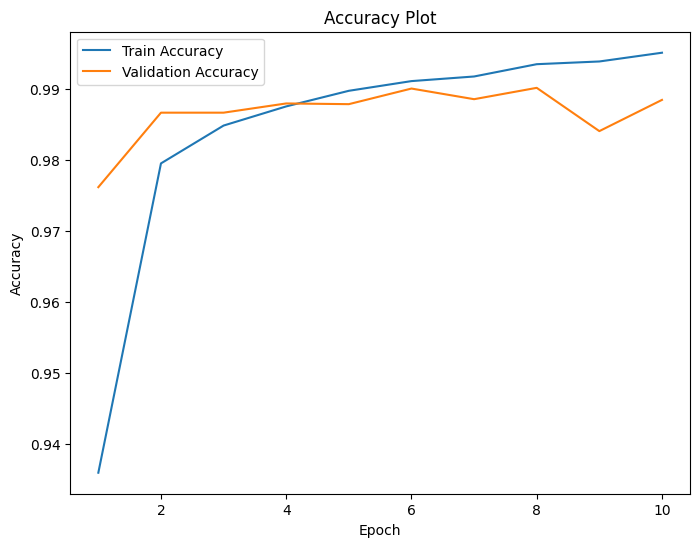

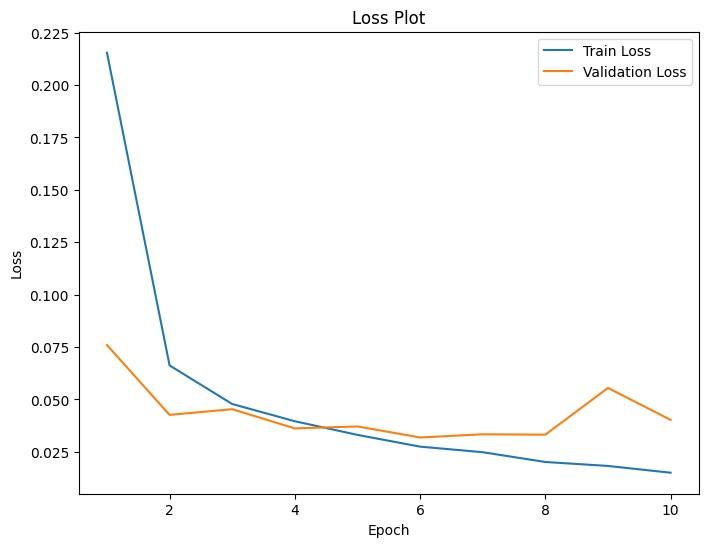

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Train the LeNet-5 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(10):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.max(1)[1] == labels).sum().item()
    train_loss /= len(train_loader)
    train_acc = train_correct / len(train_dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.max(1)[1] == labels).sum().item()
    val_loss /= len(test_loader)
    val_acc = val_correct / len(test_dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch [{epoch+1}/10], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Plot the accuracy and loss graphs
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), train_accs, label='Train Accuracy')
plt.plot(range(1, 11), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [ ]:
pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 23.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64

In [ ]:
import torch
import torchvision
import torchattacks
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import multiprocessing as mp

# Define the LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load and preprocess the MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define and train the LeNet-5 model with DeepFool attack
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

def apply_deepfool(model, images, labels):
    atk = torchattacks.DeepFool(model, steps=3, overshoot=0.02)
    return atk(images, labels)

for epoch in range(10):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        with mp.Pool(processes=1) as pool:
            adv_images = pool.apply_async(apply_deepfool, args=(model, images, labels)).get()

        optimizer.zero_grad()
        outputs = model(adv_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.max(1)[1] == labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = train_correct / len(train_dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.max(1)[1] == labels).sum().item()

    val_loss /= len(test_loader)
    val_acc = val_correct / len(test_dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch [{epoch+1}/10], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Plot the accuracy and loss graphs
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), train_accs, label='Train Accuracy')
plt.plot(range(1, 11), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

Process ForkPoolWorker-3:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.10/dist-packages/torch/multiprocessing/reductions.py", line 147, in rebuild_cuda_tensor
    torch.cuda._lazy_init()
  File "/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py", line 288, in _lazy_init
    raise RuntimeError(
RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


KeyboardInterrupt: 

In [8]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def model_train(device, model, opt, epochs, loader_train, loader_val,
                   print_step=1, clip_min=None, clip_max=None, adv_args=None,
                   is_fgsm=True, has_labels=False, l2_norm=True, verbose=True):
    """
    Function is used to train the model with clean images of the dataset, or
    adversarial images of the dataset if adversarial parameters are passed to
    the function.

    Input Variables:
        device       : Device to forward the tensors to (CPU or GPU)
        model        : Model to train with the training set
        opt          : Optimizer used for training the model
        epochs       : Number of iterations the model is trained on the dataset
        loader_train : Dataset loader for the training set
        loader_val   : Dataset loader for the validation set
        print_step   : Epoch interval to print training and validation results
                       (Default = 1)
        clip_min     : Minimum boundary of the adversarial images
                       (Default = None)
        clip_max     : Maximum boundary of the adversarial images
                       (Default = None)
        adv_args     : Epsilon parameter for FGSM or parameters for DeepFool
                       eps or [batch_size, num_classes, overshoot, max_iters]
                       (Default = None)
        is_fgsm      : Flag used to set the adversarial method for training
                       as FGSM, or DeepFool if false
                       (Default = True)
        has_labels   : Flag used to determine if the DeepFool adversarial
                       attack has access to the true labels of the dataset
                       (Default = False)
        l2_norm      : Flag used to determine if DeepFool perturbations use L2
                       norm, else if set to false, L-inf norm is used instead
                       (Default = True)
        verbose      : Prints the training acc/loss per epoch if set to True
                       (Default = True)

    Output_Variables:
        train_accs   : List containing training accuracy for each epoch
        train_losses : List containing training loss for each epoch
        val_accs     : List containing validation accuracy for each epoch
        val_losses   : List containing validation loss for each epoch
    """

    if (clip_min is None) or (clip_min is None) or (adv_args is None):
        is_adv = False
    else:
        is_adv = True

    loss_fn = nn.CrossEntropyLoss()

    train_accs = []
    train_losses = []

    val_accs = []
    val_losses = []

    for epoch in range(epochs):
        correct = 0
        losses = []

        model.train()

        for images, labels in loader_train:
            images, labels = images.to(device), labels.to(device)

            if is_adv:
                model.eval()
                if is_fgsm:
                    images_input, _, _, _ = fgsm(
                        model, clip_min, clip_max, images, labels, adv_args)
                elif has_labels:
                    images_input, _, _, _, _ = deepfool(
                        model, clip_min, clip_max, images, labels, l2_norm,
                        adv_args[0], adv_args[1], adv_args[2], adv_args[3])
                else:
                    images_input, _, _, _, _ = deepfool(
                        model, clip_min, clip_max, images, None, l2_norm,
                        adv_args[0], adv_args[1], adv_args[2], adv_args[3])
                model.train()
            else:
                images_input = images

            opt.zero_grad()

            outputs = model(images_input)
            loss = loss_fn(outputs, labels)

            correct += (outputs.max(dim=1)[1] == labels).sum().item()
            losses.append(loss.item())

            loss.backward()
            opt.step()

            del images, labels, images_input, outputs

        train_acc = correct / len(loader_train.dataset)
        train_loss = np.mean(losses)

        train_accs.append(train_acc)
        train_losses.append(train_loss)

        correct = 0
        losses = []

        model.eval()

        for images, labels in loader_val:
            images, labels = images.to(device), labels.to(device)

            if is_adv:
                if is_fgsm:
                    images_input, _, _, _ = fgsm(
                        model, clip_min, clip_max, images, labels, adv_args)
                elif has_labels:
                    images_input, _, _, _, _ = deepfool(
                        model, clip_min, clip_max, images, labels, l2_norm,
                        adv_args[0], adv_args[1], adv_args[2], adv_args[3])
                else:
                    images_input, _, _, _, _ = deepfool(
                        model, clip_min, clip_max, images, None, l2_norm,
                        adv_args[0], adv_args[1], adv_args[2], adv_args[3])
            else:
                images_input = images

            with torch.no_grad():
                outputs = model(images_input)
                loss = loss_fn(outputs, labels)

            correct += (outputs.max(dim=1)[1] == labels).sum().item()
            losses.append(loss.item())

            del images, labels, images_input, outputs

        val_acc = correct / len(loader_val.dataset)
        val_loss = np.mean(losses)

        val_accs.append(val_acc)
        val_losses.append(val_loss)

        if verbose and (epoch == 0 or (epoch + 1) % print_step == 0):
            print('Epoch [{:d}]'.format(epoch + 1))
            print('    Train Acc : {:.4f},  Train Loss : {:.4f}'\
                .format(train_acc, train_loss))
            print('      Val Acc : {:.4f},    Val Loss : {:.4f}'\
                .format(val_acc, val_loss))

    # Plotting training accuracy and loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_accs, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_accs, train_losses, val_accs, val_losses


def model_eval(device, model, loader_test, clip_min=None, clip_max=None,
               adv_args=None, is_fgsm=True, has_labels=False, l2_norm=True,
               verbose=True):
    """
    Function is used to evaluate the model with clean images of the dataset, or
    adversarial images of the dataset if adversarial parameters are passed to
    the function.

    Input Variables:
        device      : Device to forward the tensors to (CPU or GPU)
        model       : Model to evaluate with the test set
        loader_test : Dataset loader for the testing set
        clip_min    : Minimum boundary of the adversarial images
                      (Default = None)
        clip_max    : Maximum boundary of the adversarial images
                      (Default = None)
        adv_args    : Epsilon parameter for FGSM or parameters for DeepFool
                      eps or[batch_size, num_classes, overshoot, max_iters]
                      (Default = None)
        is_fgsm     : Flag used to set the adversarial method for evaluation
                      as FGSM, or DeepFool if false
                      (Default = True)
        has_labels  : Flag used to determine if the DeepFool adversarial
                      attack has access to the true labels of the dataset
                      (Default = False)
        l2_norm     : Flag used to determine if DeepFool perturbations use L2
                      norm, else if set to false, L-inf norm is used instead
                      (Default = True)
        verbose     : Prints the testing acc/loss if set to True
                      (Default = True)

    Output_Variables:
        test_acc  : Testing set accuracy of the model
        test_loss : Testing set loss of the model
    """

    if (clip_min is None) or (clip_min is None) or (adv_args is None):
        is_adv = False
    else:
        is_adv = True

    loss_fn = nn.CrossEntropyLoss()

    correct = 0
    losses = []

    model.eval()

    for images, labels in loader_test:
        images, labels = images.to(device), labels.to(device)

        if is_adv:
            if is_fgsm:
                images_input, _, _, _ = fgsm(
                    model, clip_min, clip_max, images, labels, adv_args)
            elif has_labels:
                images_input, _, _, _, _ = deepfool(
                    model, clip_min, clip_max, images, labels, l2_norm,
                    adv_args[0], adv_args[1], adv_args[2], adv_args[3])
            else:
                images_input, _, _, _, _ = deepfool(
                    model, clip_min, clip_max, images, None, l2_norm,
                    adv_args[0], adv_args[1], adv_args[2], adv_args[3])
        else:
            images_input = images

        with torch.no_grad():
            outputs = model(images_input)
            loss = loss_fn(outputs, labels)

        correct += (outputs.max(dim=1)[1] == labels).sum().item()
        losses.append(loss.item())

        del images, labels, images_input, outputs

    test_acc = correct / len(loader_test.dataset)
    test_loss = np.mean(losses)

    if verbose:
        if is_adv:
            if is_fgsm:
                print('Evaluation (FGSM Images)')
            else:
                print('Evaluation (DeepFool Images)')
        else:
            print('Evaluation (Clean Images)')
        print('     Test Acc : {:.4f},   Test Loss : {:.4f}'\
            .format(test_acc, test_loss))

    return test_acc, test_loss


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1]
    Train Acc : 0.0324,  Train Loss : 0.8589
      Val Acc : 0.0325,    Val Loss : 0.8534
Epoch [2]
    Train Acc : 0.0336,  Train Loss : 0.8136
      Val Acc : 0.0349,    Val Loss : 0.8029
Epoch [3]
    Train Acc : 0.0324,  Train Loss : 0.7925
      Val Acc : 0.0318,    Val Loss : 0.8014
Epoch [4]
    Train Acc : 0.0320,  Train Loss : 0.7817
      Val Acc : 0.0308,    Val Loss : 0.7790
Epoch [5]
    Train Acc : 0.0322,  Train Loss : 0.7755
      Val Acc : 0.0310,    Val Loss : 0.7727


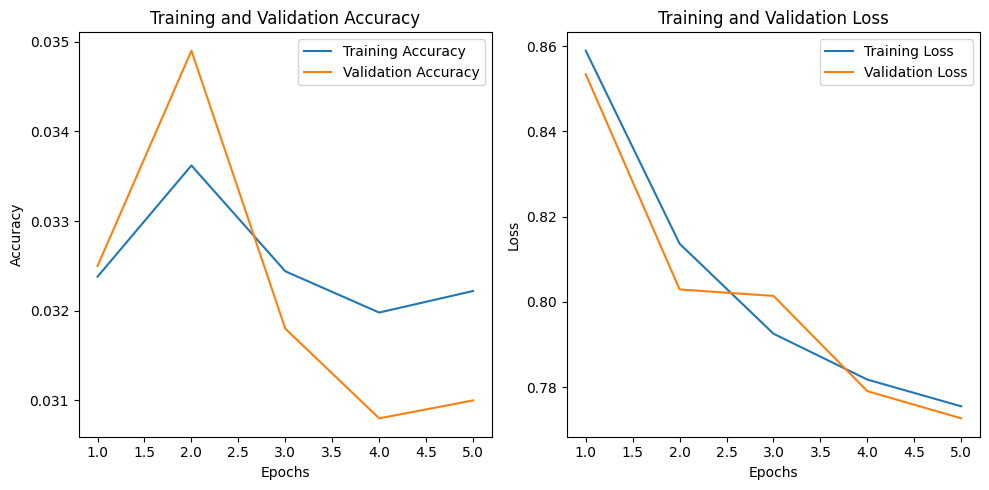

In [12]:
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('/content/weights/clean/mnist_lenet-2.pth'))

if train_model:
    opt = torch.optim.SGD(model.parameters(),
                          lr=lr * lr_scale,
                          momentum=momentum)
    _, _, _, _, = model_train(device, model, opt, 5,
                              mnist_loader_train, mnist_loader_val,
                              1, mnist_min, mnist_max,
                              deep_args, is_fgsm=False)